In [42]:
# pip install s3fs
# pip install -U kaleido

In [43]:
import pandas as pd
import boto3
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import plotly.express as px
from collections import Counter
pd.set_option('display.max_columns', None)

## Helper Functions

In [44]:
def plot_tone(df_all, time_period = "Daily"):
    sns.lineplot(x = "date", y = "tone_avg",data=df_all)
    sns.set(style='dark')
    plt.title(f"{time_period} Average Tone, 2015-2022 - Prio Grid 168997")
    plt.xlabel("Date")
    plt.ylabel("Tone")
    plt.show()
    
def plot_tone_plotly(df_all, time_period = "Daily"):
    fig = px.line(df_all, x='date', y="tone_avg")
    fig.update_layout(
        title=f"{time_period} Average Tone, 2015-2022 - Prio Grid 168997",
        xaxis_title="Date",
        yaxis_title="Tone")
    fig.write_image(f"Tone_168997_{time_period}.png")
    fig.show()

# Reading Data

In [45]:
df_all = pd.DataFrame()
for year in range(2015,2023):
    print(year)
    df = pd.read_csv(f"s3://shrivats-dev/Tasks/PrioGrid168997/Tone/Daily/{year}/*.csv")
    df_all = pd.concat([df_all,df])
df_all['date'] = pd.to_datetime(df_all[["year", "month", "day"]])
df_all.head()

2015
2016
2017
2018
2019
2020
2021
2022


,GRID_IDs,year,month,day,themes,organizations,tone_avg,date
0,168997,2015,10,23,"GENERAL_GOVERNMENT:213, WB_135_TRANSPORT:200, ...","Yacht Club:100, Club World:99, Azamara Club Cr...",3.567873,2015-10-23
1,168997,2015,10,16,"TAX_FNCACT_POLICE:42, SECURITY_SERVICES:41, CR...","High Court:30, United States:28, Neiman Marcus...",0.908164,2015-10-16
2,168997,2015,5,9,"TAX_FNCACT_PRINCIPAL:32, SECURITY_SERVICES:30,...","Centre For Science:4, Marigold Hotel:3, Facebo...",-2.274135,2015-05-09
3,168997,2015,3,28,"TAX_FNCACT_PRINCESS:545, TAX_WORLDLANGUAGES_NO...","Royal Caribbean:324, Crystal Cruises:216, Prin...",2.524864,2015-03-28
4,168997,2015,7,13,"CRISISLEX_O02_RESPONSEAGENCIESATCRISIS:68, CRI...","Samajwadi Party:12, Google:6, Land Office:4, H...",-1.467733,2015-07-13


In [46]:
df_tone = df_all[["GRID_IDs","year","month","day","tone_avg",'date']]
df_tone = df_tone.sort_values("date").reset_index(drop = True)
df_tone = df_tone[df_tone.date >= "2015-03-1"].reset_index(drop=True)
df_tone.head()

,GRID_IDs,year,month,day,tone_avg,date
0,168997,2015,3,1,-1.292753,2015-03-01
1,168997,2015,3,2,-0.293015,2015-03-02
2,168997,2015,3,3,-0.749725,2015-03-03
3,168997,2015,3,4,2.255083,2015-03-04
4,168997,2015,3,5,1.278214,2015-03-05


# Plotting Tone

In [47]:
df_tone_monthly = df_tone.groupby(by = ['year','month']).agg({"tone_avg":"mean", "date":"first"}).reset_index()
df_tone_monthly.head()

,year,month,tone_avg,date
0,2015,3,0.072803,2015-03-01
1,2015,4,-0.085546,2015-04-01
2,2015,5,-0.532687,2015-05-01
3,2015,6,0.418539,2015-06-01
4,2015,7,-0.218440,2015-07-01


In [48]:
df_tone_yearly = df_tone.groupby(by = ['year']).agg({"tone_avg":"mean", "date":"first"}).reset_index()
df_tone_yearly

,year,tone_avg,date
0,2015,0.080843,2015-03-01
1,2016,-0.047452,2016-01-01
2,2017,-0.539110,2017-01-01
3,2018,-0.468271,2018-01-01
4,2019,-0.241569,2019-01-01
5,2020,-1.149801,2020-01-01
6,2021,-0.396407,2021-01-01
7,2022,0.098103,2022-01-01


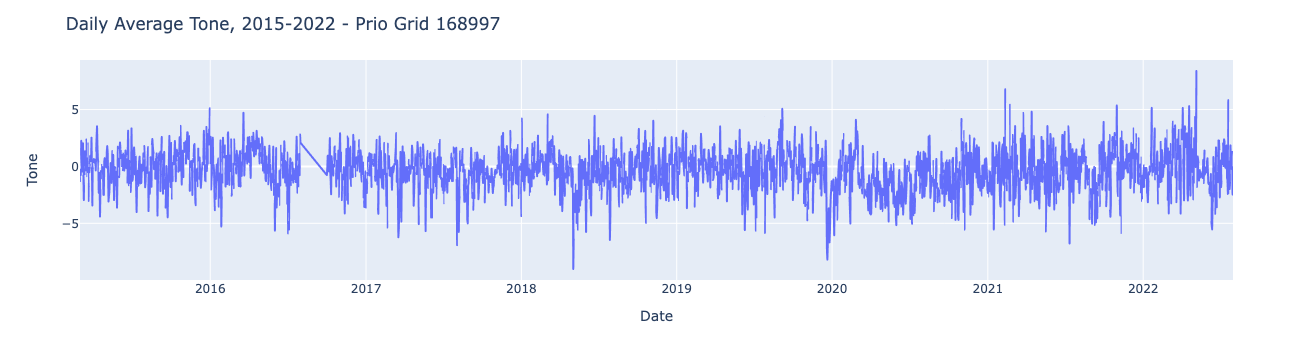

In [49]:
plot_tone_plotly(df_tone, "Daily")

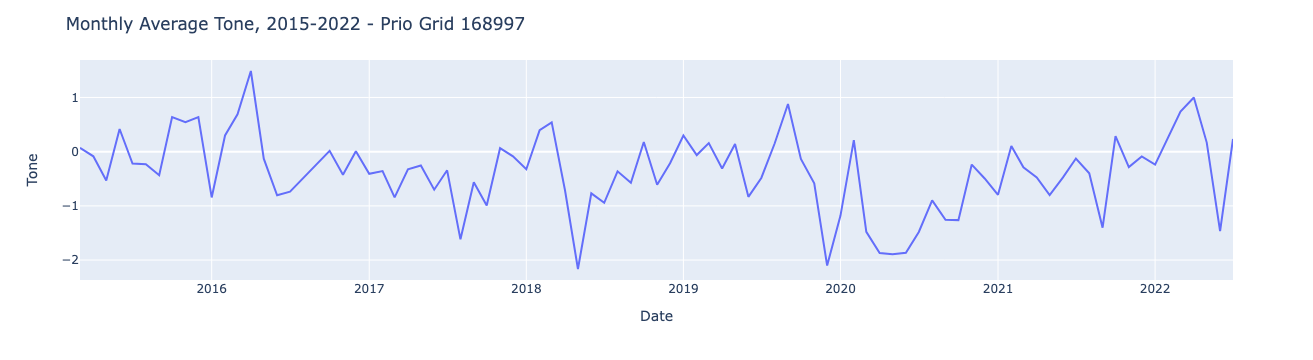

In [50]:
plot_tone_plotly(df_tone_monthly,"Monthly")

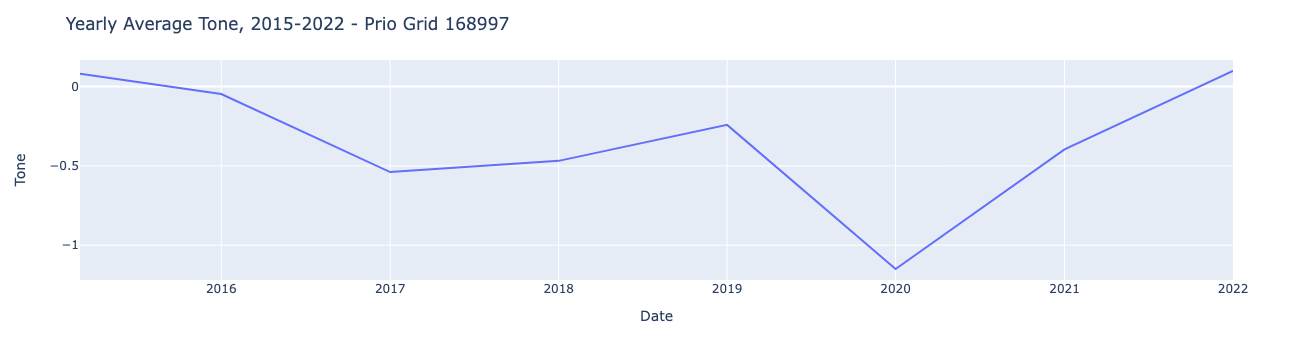

In [51]:
plot_tone_plotly(df_tone_yearly,"Yearly")

## Stacked Bar Charts

In [52]:
def group_categ(categ_count):
    counter_sum = Counter({})
    i = 0
#     print(categ_count)
    for counter_categ in categ_count:
        counter_sum += counter_categ
    return counter_sum.most_common(10)
    
def count_category(categ_str):
    return Counter({x.split(":")[0].strip():int(x.split(":")[1].strip()) for x in categ_str.split(",")})


## Themes

In [53]:
df_themes = df_all.dropna(subset = ["themes"])
df_themes['themes_count'] = df_themes['themes'].apply(count_category)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
df_themes_grp  = df_themes.groupby(by = ['year']).agg({"tone_avg":"mean", "date":"first","themes_count":group_categ}).explode("themes_count").reset_index()
# df_themes_grp[["themes1"]] = df_themes_grp['themes_count'].apply(split_categ)
df_themes_grp[["theme", "frequency"]] = df_themes_grp['themes_count'].tolist()
# df_themes_grp[['theme','frequency']].frequency.unstack().plot(kind='bar', stacked=True)
df_themes_grp

,year,tone_avg,date,themes_count,theme,frequency
0,2015,0.111488,2015-10-23,"(GENERAL_GOVERNMENT, 8892)",GENERAL_GOVERNMENT,8892
1,2015,0.111488,2015-10-23,"(TAX_FNCACT_MINISTER, 7609)",TAX_FNCACT_MINISTER,7609
2,2015,0.111488,2015-10-23,"(TOURISM, 5459)",TOURISM,5459
3,2015,0.111488,2015-10-23,"(EDUCATION, 5096)",EDUCATION,5096
4,2015,0.111488,2015-10-23,"(TAX_ETHNICITY_INDIAN, 4998)",TAX_ETHNICITY_INDIAN,4998
...,...,...,...,...,...,...
75,2022,0.098103,2022-05-10,"(TAX_ETHNICITY_HINDU, 1254)",TAX_ETHNICITY_HINDU,1254
76,2022,0.098103,2022-05-10,"(TAX_RELIGION_HINDU, 1254)",TAX_RELIGION_HINDU,1254
77,2022,0.098103,2022-05-10,"(TAX_FNCACT_MINISTER, 1163)",TAX_FNCACT_MINISTER,1163
78,2022,0.098103,2022-05-10,"(MANMADE_DISASTER_IMPLIED, 1054)",MANMADE_DISASTER_IMPLIED,1054


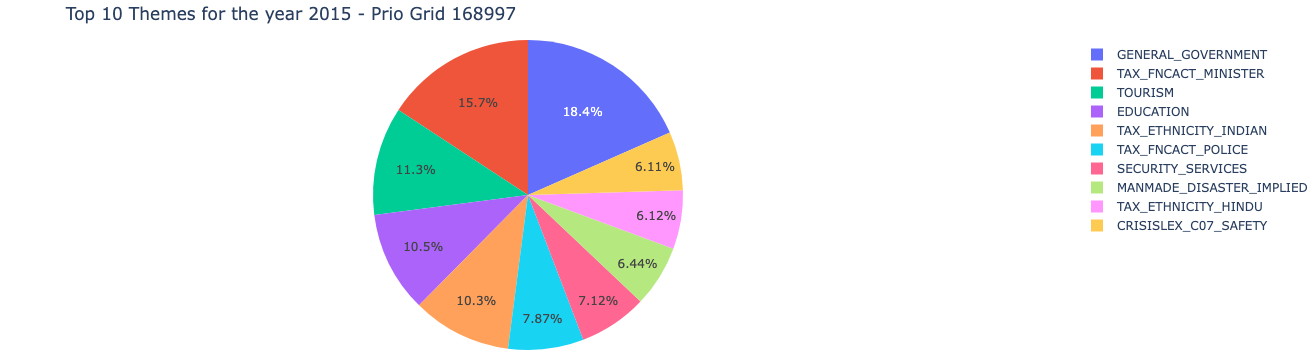

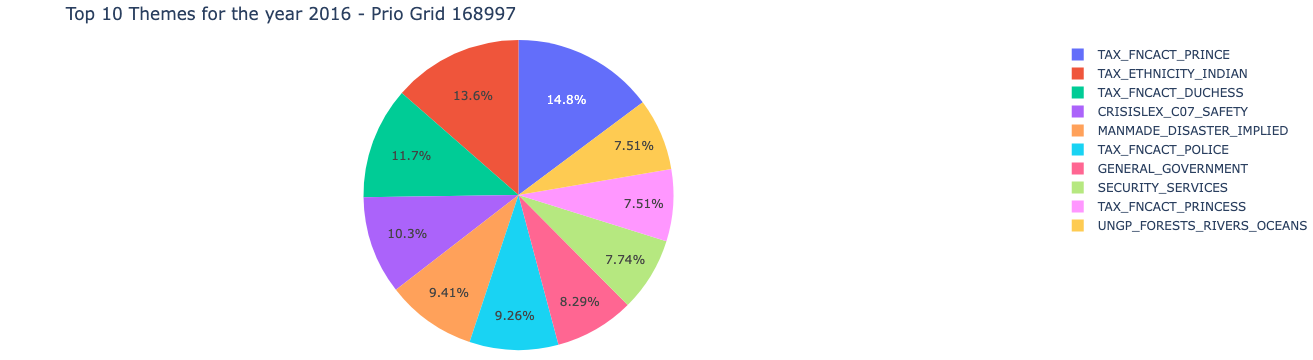

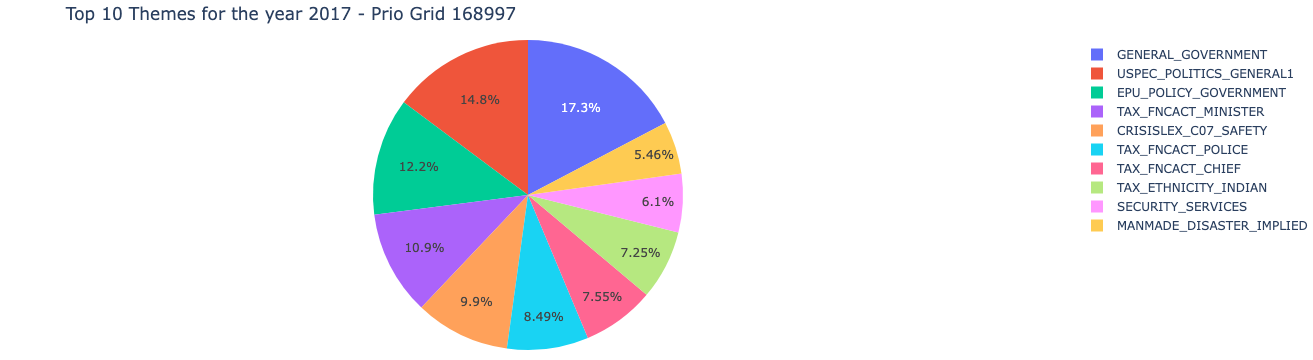

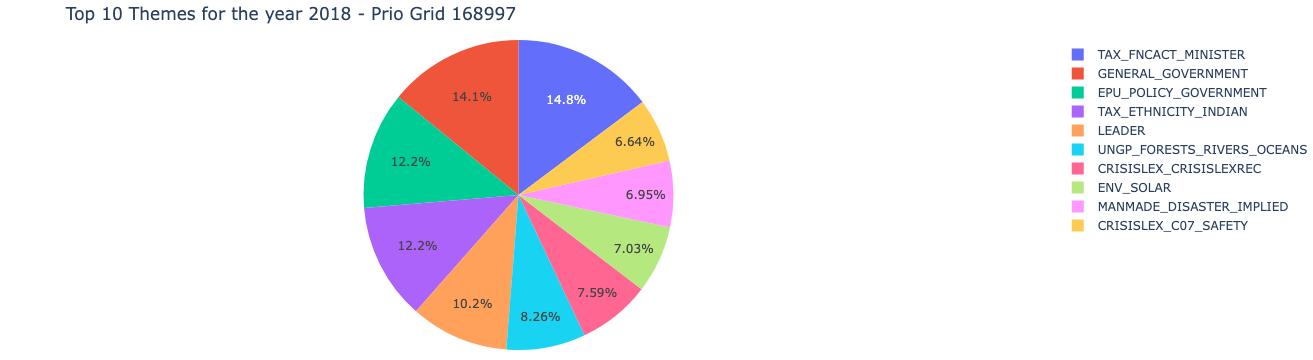

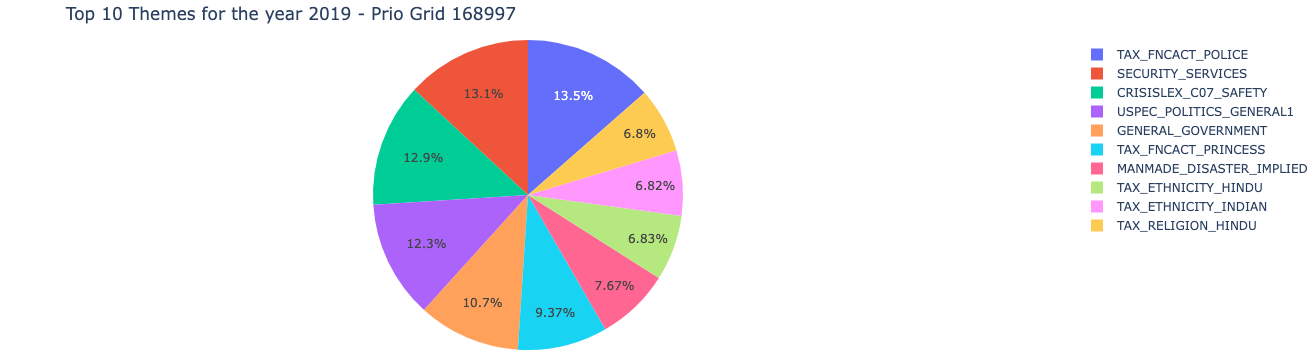

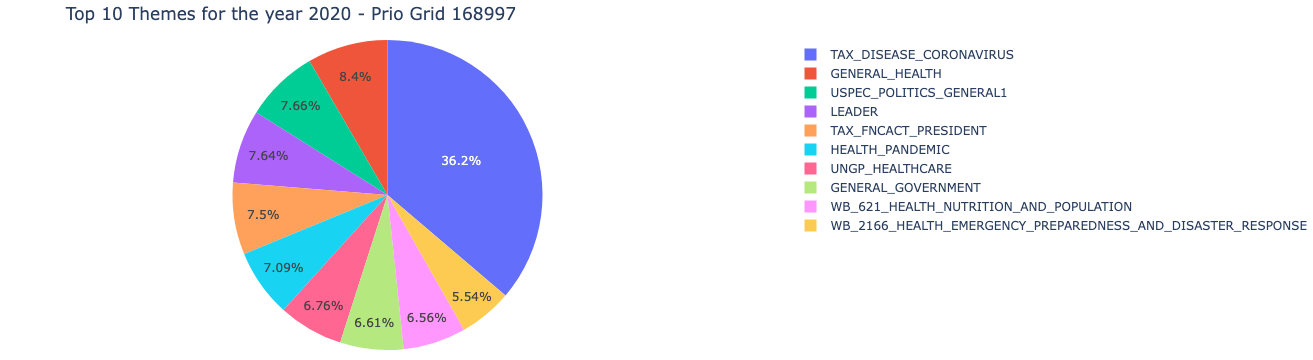

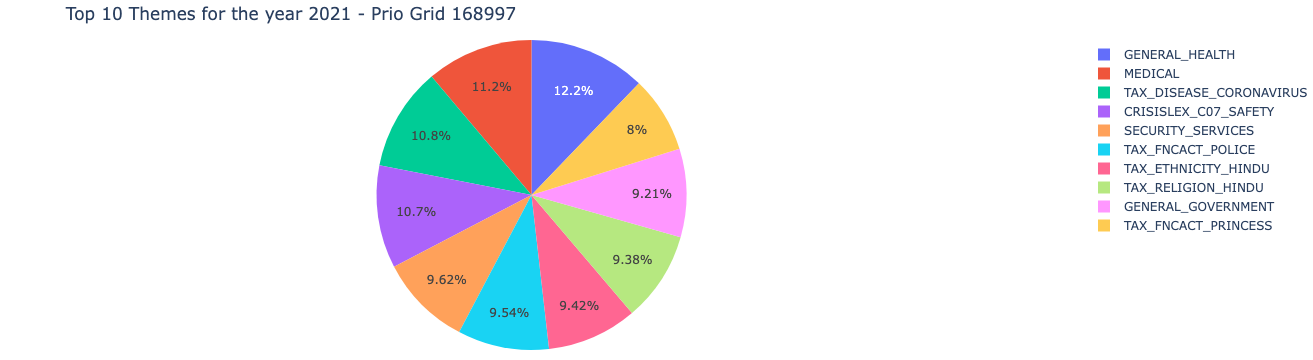

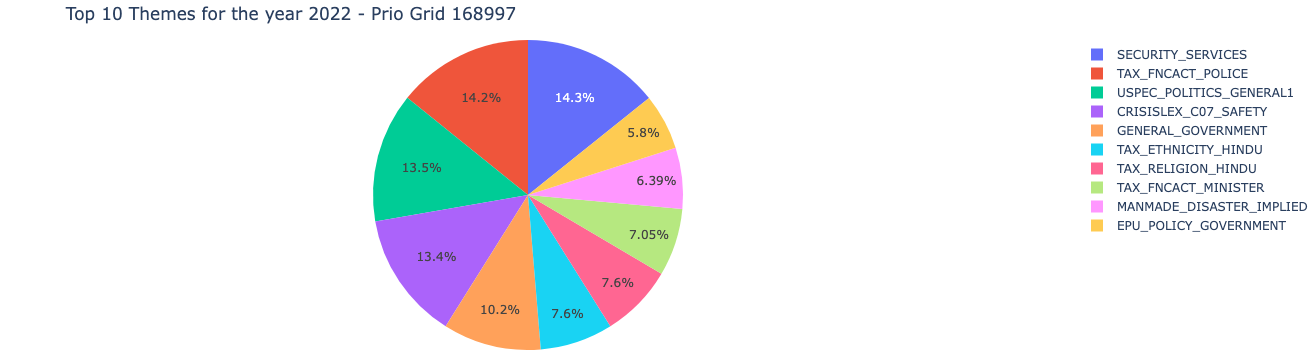

In [55]:
for year in range(2015,2023):
    df_year = df_themes_grp[df_themes_grp['year'] == year]
#     plt.pie(sizes,labels=labels, startangle= 90,  autopct='%1.2f%%')
#     plt.title(f'Top 10 Themes for the year {year} - Prio Grid 168997')
#     plt.savefig(f"Top10Themes_168997_{year}.png")
#     plt.show()
    fig = px.pie(df_year, values='frequency', names='theme', title=f'Top 10 Themes for the year {year} - Prio Grid 168997')
    fig.update_layout(margin=dict(t=40, b=10, l=0, r=0))
    print()
    fig.write_image(f"Top10Themes_168997_{year}.png")
    fig.show()


## Organizations

In [56]:
df_org = df_all.dropna(subset = ["organizations"])
df_org['org_count'] = df_org['organizations'].apply(count_category)
df_org.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,GRID_IDs,year,month,day,themes,organizations,tone_avg,date,org_count
0,168997,2015,10,23,"GENERAL_GOVERNMENT:213, WB_135_TRANSPORT:200, ...","Yacht Club:100, Club World:99, Azamara Club Cr...",3.567873,2015-10-23,"{'Yacht Club': 100, 'Club World': 99, 'Azamara..."
1,168997,2015,10,16,"TAX_FNCACT_POLICE:42, SECURITY_SERVICES:41, CR...","High Court:30, United States:28, Neiman Marcus...",0.908164,2015-10-16,"{'High Court': 30, 'United States': 28, 'Neima..."
2,168997,2015,5,9,"TAX_FNCACT_PRINCIPAL:32, SECURITY_SERVICES:30,...","Centre For Science:4, Marigold Hotel:3, Facebo...",-2.274135,2015-05-09,"{'Centre For Science': 4, 'Marigold Hotel': 3,..."
3,168997,2015,3,28,"TAX_FNCACT_PRINCESS:545, TAX_WORLDLANGUAGES_NO...","Royal Caribbean:324, Crystal Cruises:216, Prin...",2.524864,2015-03-28,"{'Royal Caribbean': 324, 'Crystal Cruises': 21..."
4,168997,2015,7,13,"CRISISLEX_O02_RESPONSEAGENCIESATCRISIS:68, CRI...","Samajwadi Party:12, Google:6, Land Office:4, H...",-1.467733,2015-07-13,"{'Samajwadi Party': 12, 'Google': 6, 'Land Off..."


In [57]:
df_org_grp  = df_org.groupby(by = ['year']).agg({"tone_avg":"mean", "date":"first","org_count":group_categ}).explode("org_count").reset_index()
# df_themes_grp[["themes1"]] = df_themes_grp['themes_count'].apply(split_categ)
df_org_grp[["organization", "frequency"]] = df_org_grp['org_count'].tolist()
# df_themes_grp[['theme','frequency']].frequency.unstack().plot(kind='bar', stacked=True)
df_org_grp

,year,tone_avg,date,org_count,organization,frequency
0,2015,0.121462,2015-10-23,"(Supreme Court, 4124)",Supreme Court,4124
1,2015,0.121462,2015-10-23,"(United States, 3630)",United States,3630
2,2015,0.121462,2015-10-23,"(Facebook, 1599)",Facebook,1599
3,2015,0.121462,2015-10-23,"(Google, 1437)",Google,1437
4,2015,0.121462,2015-10-23,"(Supreme Court List, 1404)",Supreme Court List,1404
...,...,...,...,...,...,...
75,2022,0.074072,2022-05-10,"(Twitter, 303)",Twitter,303
76,2022,0.074072,2022-05-10,"(Archaeological Survey Of India, 241)",Archaeological Survey Of India,241
77,2022,0.074072,2022-05-10,"(Google, 174)",Google,174
78,2022,0.074072,2022-05-10,"(High Court, 172)",High Court,172


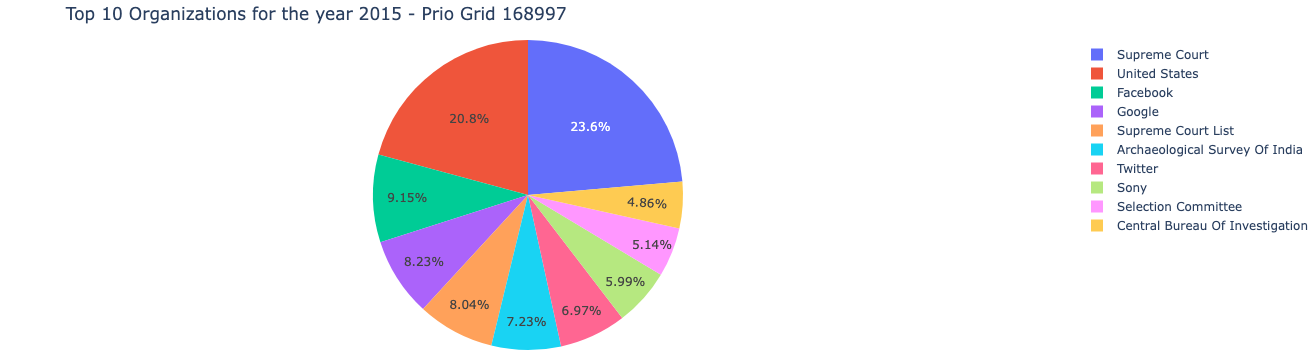

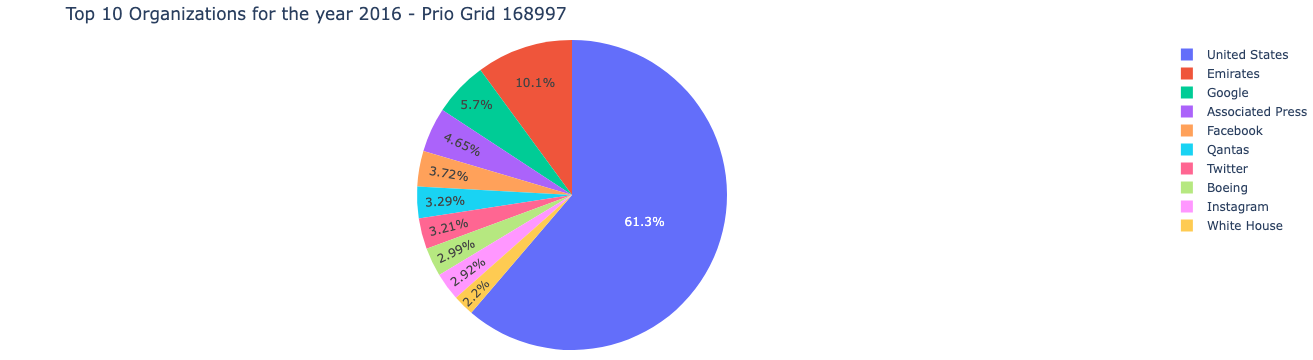

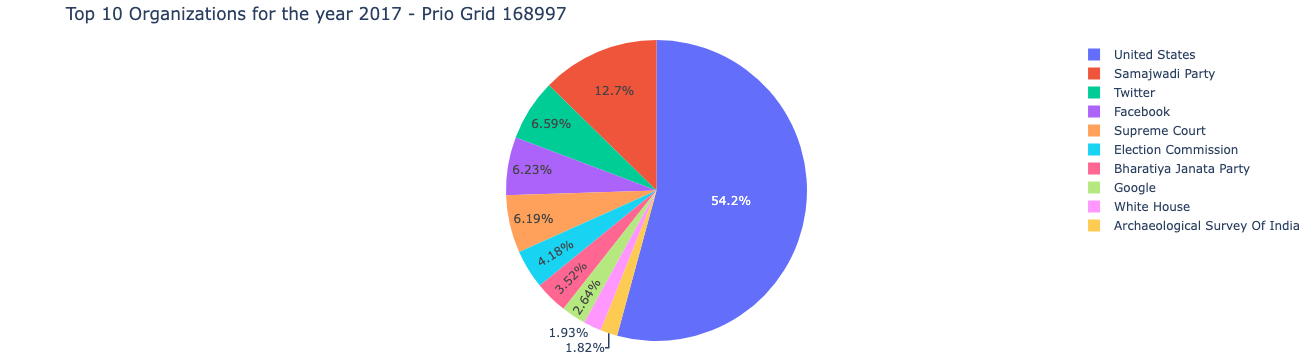

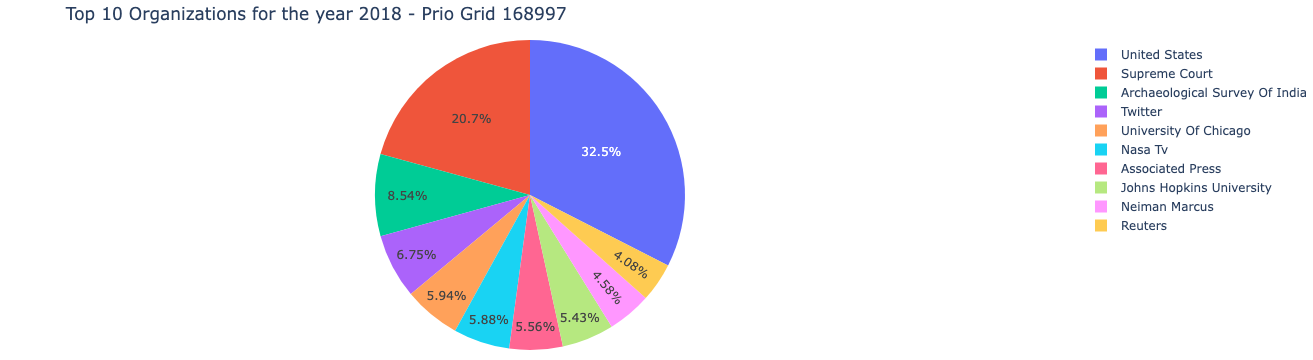

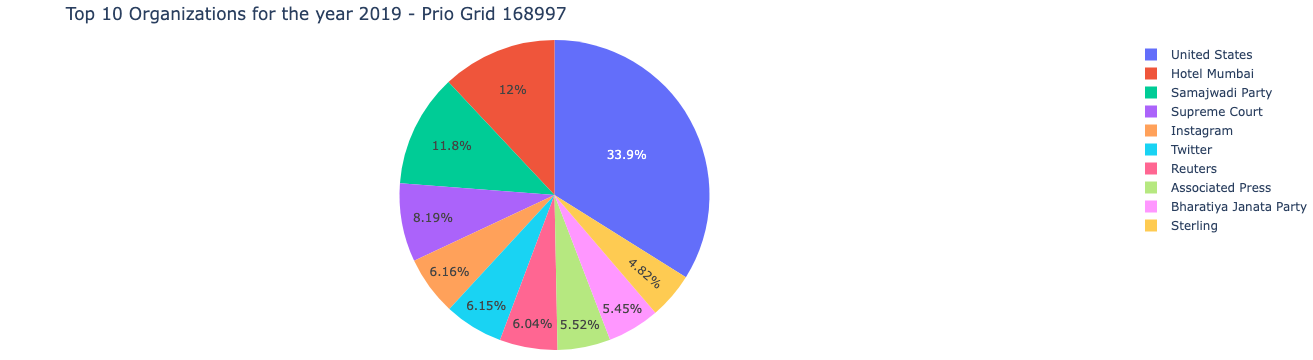

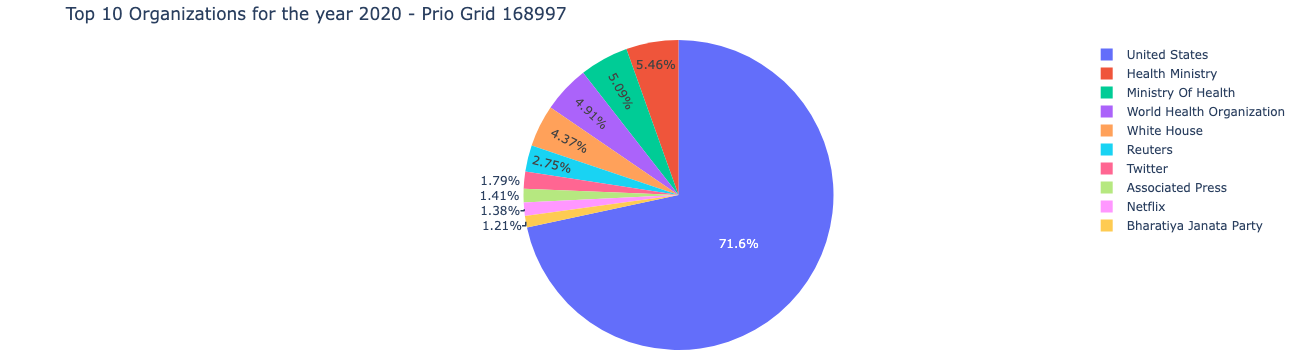

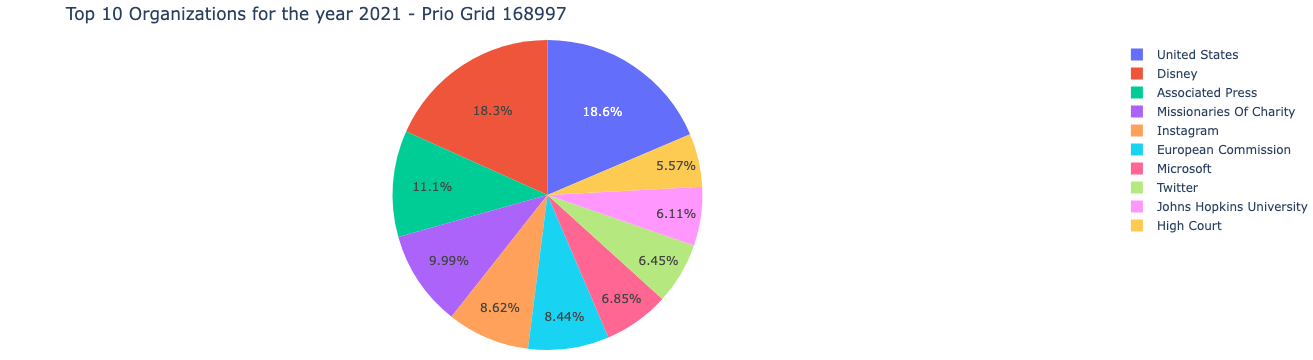

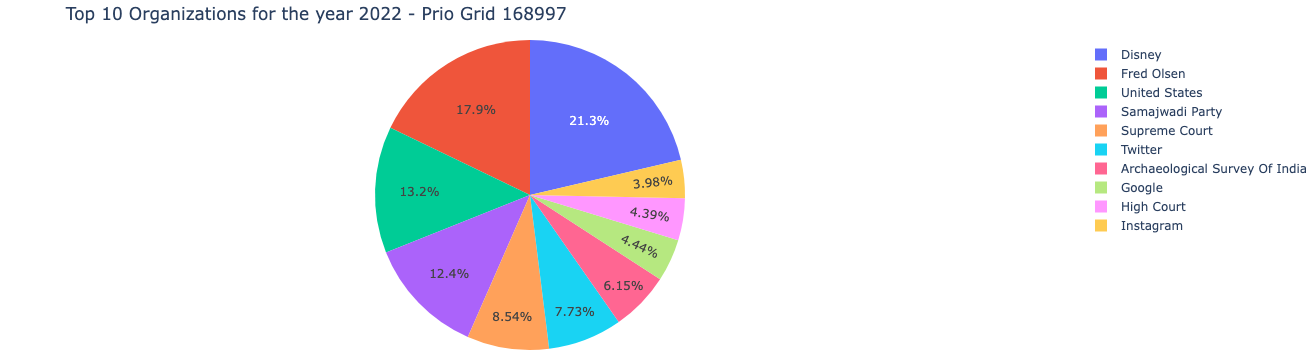

In [58]:
for year in range(2015,2023):
    df_year = df_org_grp[df_org_grp['year'] == year]
#     plt.pie(sizes,labels=labels, startangle= 90,  autopct='%1.2f%%')
#     plt.title(f'Top 10 Themes for the year {year} - Prio Grid 168997')
#     plt.savefig(f"Top10Themes_168997_{year}.png")
#     plt.show()
    fig = px.pie(df_year, values='frequency', names='organization', title=f'Top 10 Organizations for the year {year} - Prio Grid 168997')
    fig.update_layout(margin=dict(t=40, b=10, l=0, r=0))
    print()
    fig.write_image(f"Top10Organizations_168997_{year}.png")
    fig.show()
